In [1]:
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
# for Japanese Candles analysis
import matplotlib.dates as mdates
# for Elliot Wave analysis
from scipy.signal import find_peaks

In [ ]:
!pip install mplfinance

In [2]:
def download_stock_data(symbol, start, end):
    """
    Download stock data from yfinance.
    """
    data = yf.download(symbol, start=start, end=end)
    return data

def calculate_ema(data, period, column='Close'):
    """
    Calculate Exponential Moving Average (EMA) for a given period.
    """
    return data[column].ewm(span=period, adjust=False).mean()

def identify_support_levels(data, window=20):
    """
    Identify potential support levels based on recent lows within a specified window.
    """
    # Find the minimum close price within the specified window
    recent_lows = data['Close'].rolling(window=window).min()
    support_levels = recent_lows[-window:].dropna().unique()  # Get unique recent low prices as support levels
    return support_levels

def vegas_channel_analysis(data):
    """
    Perform Vegas Channel Analysis by calculating the necessary EMAs.
    """
    # Calculate EMAs for the Vegas Tunnel (144 and 169 periods)
    data['EMA_144'] = calculate_ema(data, 144)
    data['EMA_169'] = calculate_ema(data, 169)
    
    # Calculate shorter-term EMAs (12 and 24 periods)
    data['EMA_12'] = calculate_ema(data, 12)
    data['EMA_24'] = calculate_ema(data, 24)
    
    return data

def candle_calculate_emas(data, short_period_1=144, short_period_2=169, long_period=365):
    """
    Calculate the exponential moving averages (EMAs) for the Vegas channel analysis.
    """
    #data['EMA_144'] = data['Close'].ewm(span=short_period_1, adjust=False).mean()
    data['EMA_144'] = calculate_ema(data, short_period_1)
    #data['EMA_169'] = data['Close'].ewm(span=short_period_2, adjust=False).mean()
    data['EMA_169'] = calculate_ema(data, short_period_2)
    #data['EMA_365'] = data['Close'].ewm(span=long_period, adjust=False).mean()
    data['EMA_365'] = calculate_ema(data, long_period)
    
    return data

In [3]:
def plot_candlestick_with_vegas_and_support(data):
    """
    Plot candlesticks, Vegas channels, support levels, and volume.
    """
    # Prepare figure and subplots
    fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    
    # Format date for x-axis
    #data['Date'] = data.index
    ax1.xaxis_date()
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    fig.autofmt_xdate()

    # Plot candlesticks
    for i in range(len(data)):
        open_price = data['Open'][i]
        close_price = data['Close'][i]
        high_price = data['High'][i]
        low_price = data['Low'][i]
        
        # Color settings for up (green) and down (red) candles
        color = 'green' if close_price >= open_price else 'red'
        
        # Draw the candle's body
        ax1.add_patch(plt.Rectangle((i - 0.2, min(open_price, close_price)),
                                    0.4, abs(close_price - open_price),
                                    color=color, alpha=0.6))
        
        # Draw the candle's wick
        ax1.plot([i, i], [low_price, high_price], color=color, linewidth=0.8)

    # Plot the Vegas channels
    ax1.plot(data.index, data['EMA_144'], label='EMA 144', color='green', linestyle='--')
    ax1.plot(data.index, data['EMA_169'], label='EMA 169', color='orange', linestyle='--')
    ax1.plot(data.index, data['EMA_365'], label='EMA 365', color='red', linestyle='--')

    # Highlight latest close price
    latest_close = data['Close'].iloc[-1]
    latest_date = data.index[-1]
    ax1.scatter(latest_date, latest_close, color='black', zorder=5, label=f'Latest Close: {latest_close:.2f}')
    ax1.axhline(latest_close, color='black', linestyle=':', alpha=0.7)

    # Plot support levels
    support_levels = identify_support_levels(data)
    for level in support_levels:
        ax1.axhline(level, color='purple', linestyle='--', alpha=0.5, label=f'Support Level: {level:.2f}')

    # Labels and legend for ax1 (price chart)
    ax1.set_title(f"Candlestick Chart with Vegas Channels and Support Levels for {symbol}")
    ax1.set_ylabel('Price')
    ax1.legend(loc='best')
    ax1.grid(True)

    # Plot volume on ax2
    ax2.bar(data.index, data['Volume'], color='gray', alpha=0.7)
    ax2.set_ylabel('Volume')
    ax2.set_xlabel('Date')
    ax2.grid(True)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()
    
def analyze_stock_with_candlestick_and_support(stock_data):
    """
    Perform the full candlestick chart analysis for a given stock, including Vegas channels, support levels, and volume.
    """
    
    # Calculate Vegas channel EMAs
    stock_data = candle_calculate_emas(stock_data)
    #print(stock_data)
    
    # Plot candlestick chart with Vegas channels, support levels, and volume
    plot_candlestick_with_vegas_and_support(stock_data)

In [4]:
def plot_vegas_channel(data, symbol):
    """
    Plot the stock's closing prices along with the Vegas Tunnel (144 and 169 EMAs) and shorter-term EMAs.
    """
    # Info about stock
    stock = yf.Ticker(symbol)
    info = stock.info
    try:
        sector = info['sector'] or "Undef"
    except KeyError:
        sector = "ETF"

    latest_close = data['Close'].iloc[-1]
    latest_date = data.index[-1]
    # Identify support levels
    support_levels = identify_support_levels(data)
    
    # create subplots so I can see volume of stocks
    fig, (ax1, ax2) = plt.subplots(2, figsize=(12,10), sharex=True, gridspec_kw={'height_ratios': [3,1]})
    
    # Plot the closing prices
    ax1.plot(data['Close'], label='Close Price', color='blue', alpha=0.5)
    
    # Plot support levels
    for level in support_levels:
        ax1.axhline(level, color='purple', linestyle='--', alpha=0.5, label=f'Support Level: {level:.2f}')
    
    # Plot the Vegas Tunnel (EMA 144 and EMA 169)
    ax1.plot(data['EMA_144'], label='EMA 144', color='green', linestyle='--')
    ax1.plot(data['EMA_169'], label='EMA 169', color='red', linestyle='--')
    
    # Plot the shorter-term EMAs (EMA 12 and EMA 24)
    ax1.plot(data['EMA_12'], label='EMA 12', color='purple')
    ax1.plot(data['EMA_24'], label='EMA 24', color='orange')
    
    # Hightlight latest close price
    ax1.scatter(latest_date, latest_close, color='black', zorder=5, label=f"Latests Close: {latest_close:.2f}")
    ax1.axhline(latest_close, color='black', linestyle=':', alpha=0.7)
    
    # Customize the plot
    ax1.set_title(f'{latest_date}-Vegas Channel Analysis for {symbol}-{sector}')
    ax1.set_ylabel('Price')
    ax1.legend(loc='best')
    ax1.grid(True)
    
    # Plot volume on ax2
    ax2.bar(data.index, data['Volume'], fill='lightblue', color='green', alpha=0.7)
    ax2.set_ylabel('Volume')
    ax2.set_xlabel('Date')
    ax2.grid(True)
    
    # adjust layout
    plt.tight_layout()
    plt.show()

In [5]:
# analyze portfolio of stocks
stocks = ["AAPL", 'TCPC', 'AMZN', 'CHWY', 'MSFT', 'PE&OLES.MX', 'QQQ', 'V']
# Define empty lists to store data
symbols = []
prices = []
shares = []
values = []
for syms in stocks:
    stock = yf.Ticker(syms)
    #print(stock.info)
    current_price = float(stock.info.get('currentPrice'))
    current_share = stock.info.get('floatShares')
    print(type(stock.info.get('floatShares')))
    current_value = current_price * current_share
    
    # Append data to lists
    symbols.append(syms)
    prices.append(current_price)
    shares.append(current_share)
    values.append(current_value)

# Create DataFrame
portfolio_stocks_bench_df = pd.DataFrame({
    'Symbol': symbols,
    'Price': prices,
    'Shares': shares,
    'Value': values
})

portfolio_stocks_bench_df.head()

<class 'int'>
<class 'NoneType'>


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

[*********************100%%**********************]  1 of 1 completed


Check tendence, is going up


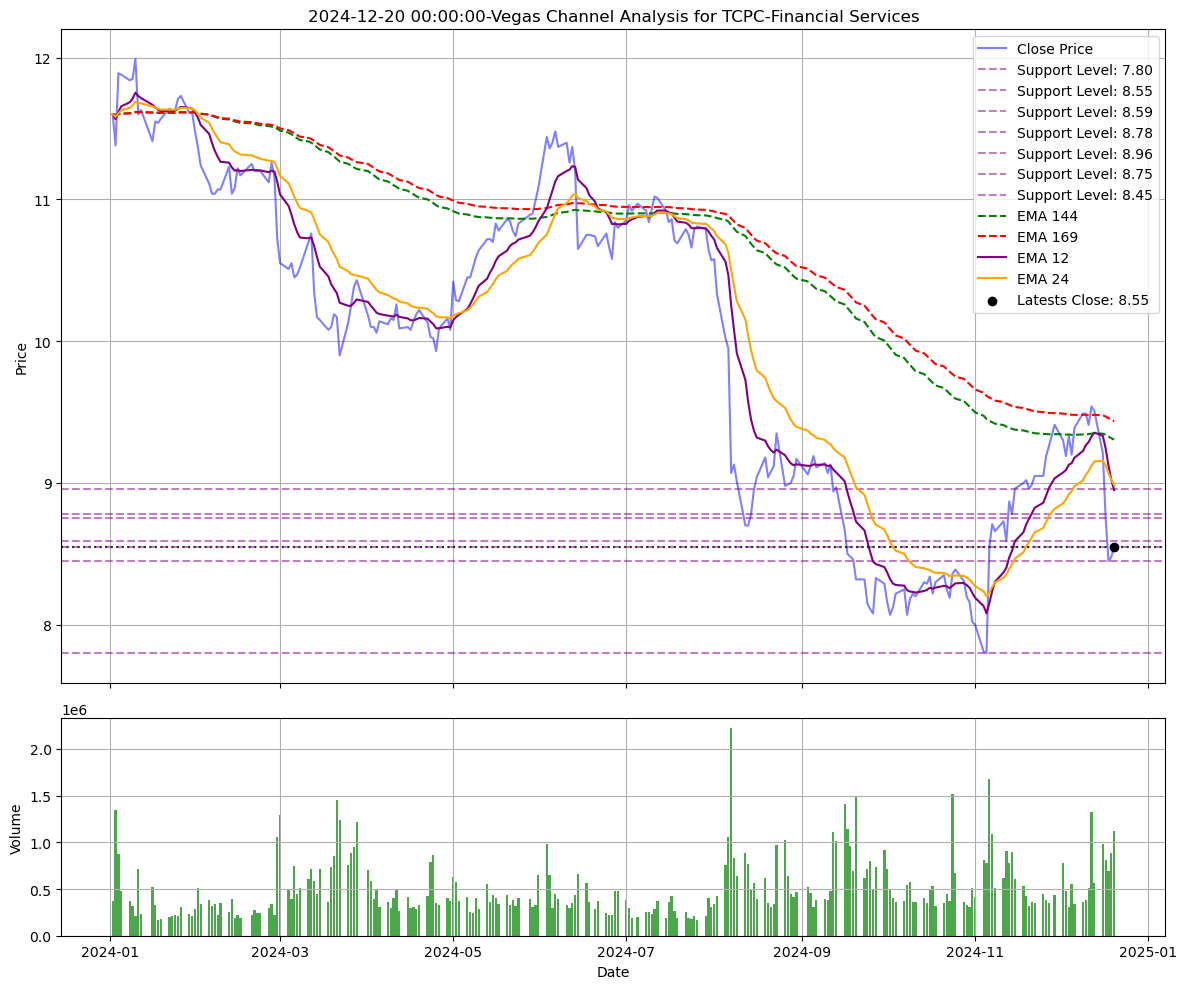

In [6]:
# Stock symbol and date range
symbol = 'TCPC'  # BlackRock TCP Capital Corp
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)
# looking for new values after leaving my portfolio
price_close = stock_data['Close'].iloc[-1]
if price_close > 8.36:
    print("Check tendence, is going up")

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol)
plt.close()

[*********************100%%**********************]  1 of 1 completed


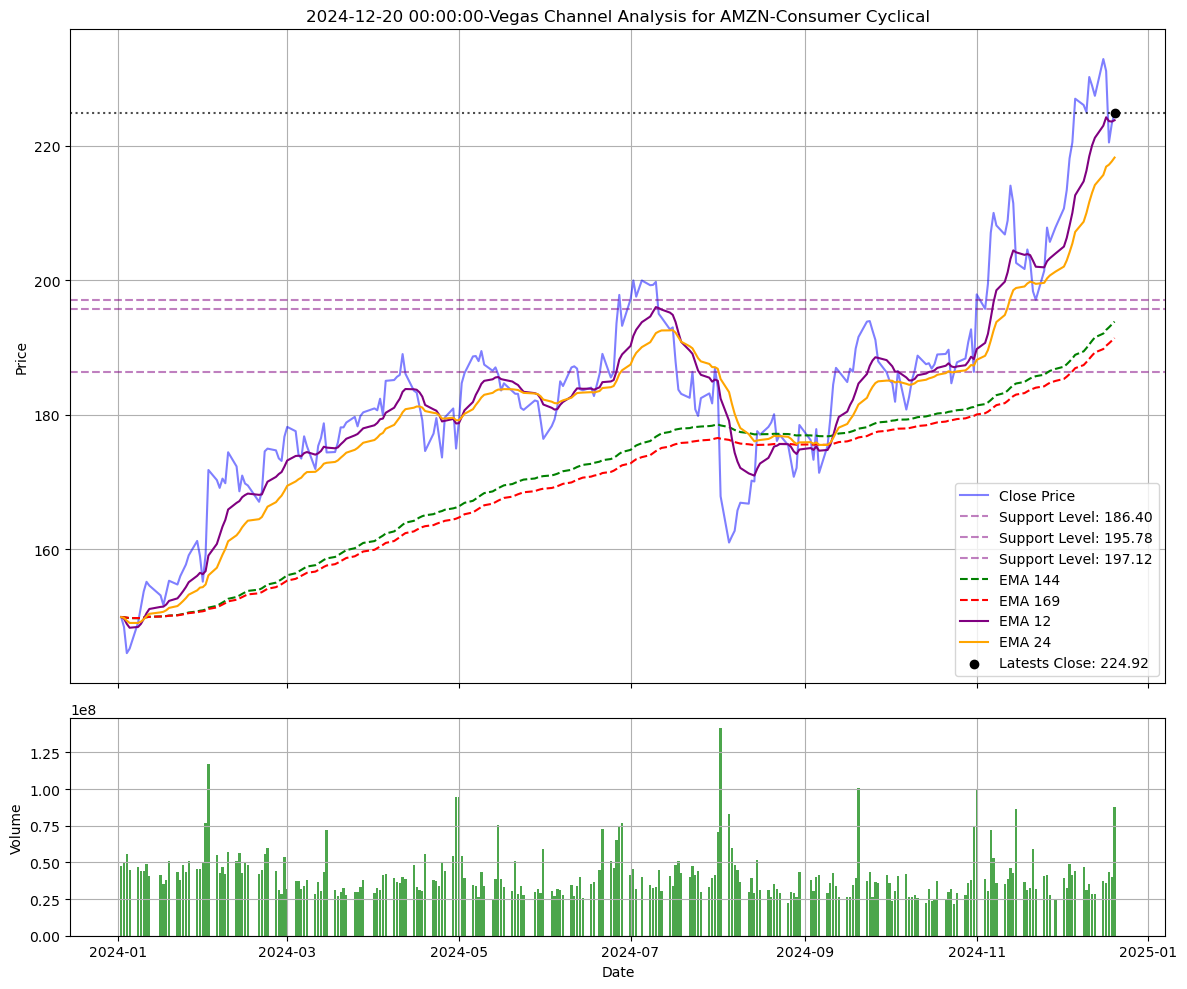

In [7]:
# Stock symbol and date range
symbol = 'AMZN'  # Amazon
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol)
plt.close()

# Perform candlestick analysis with Vegas channels and support levels
#analyze_stock_with_candlestick_and_support(stock_data)

[*********************100%%**********************]  1 of 1 completed


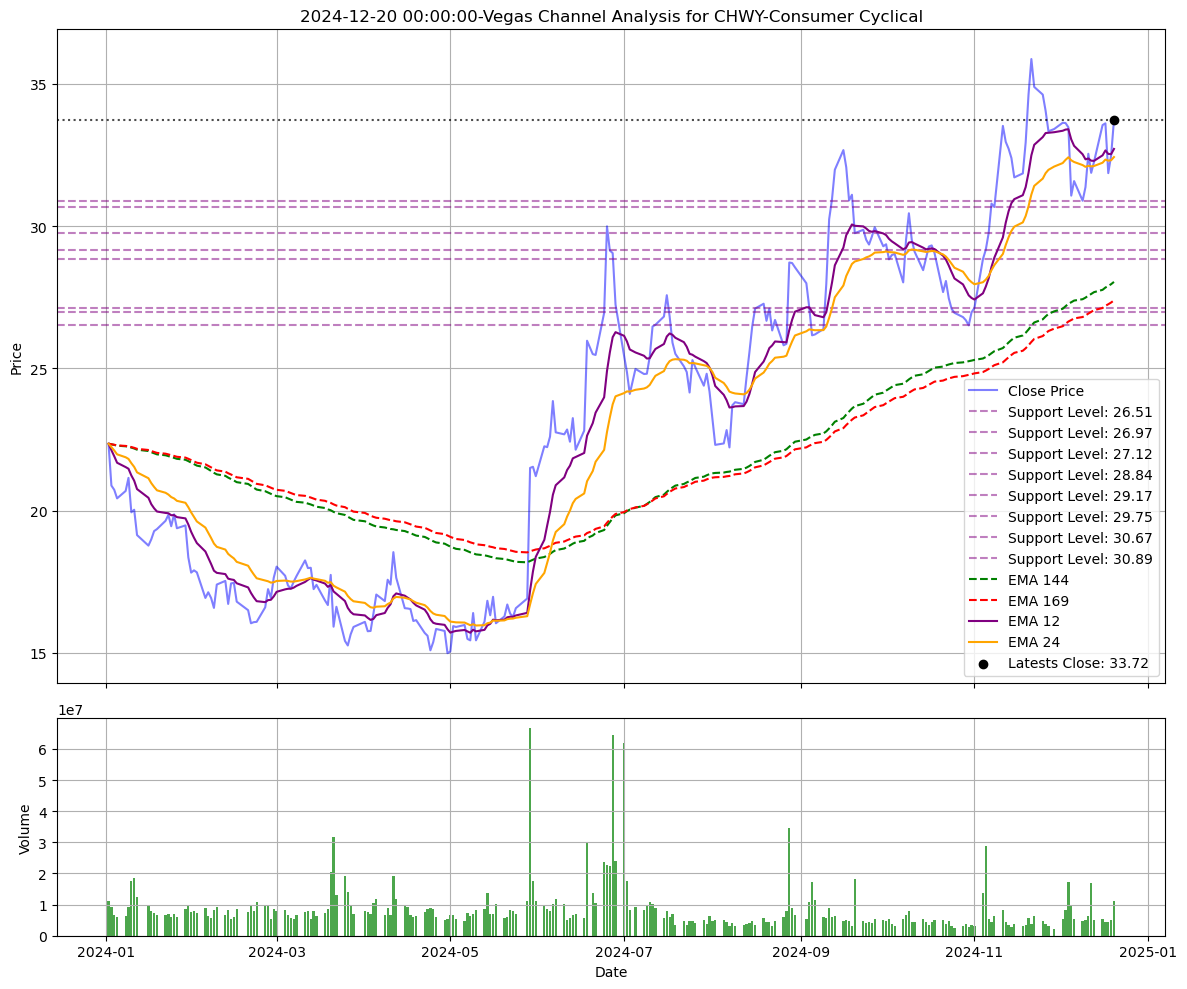

In [8]:
# Stock symbol and date range
symbol = 'CHWY'  # CHEWY
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol)
plt.close()

[*********************100%%**********************]  1 of 1 completed


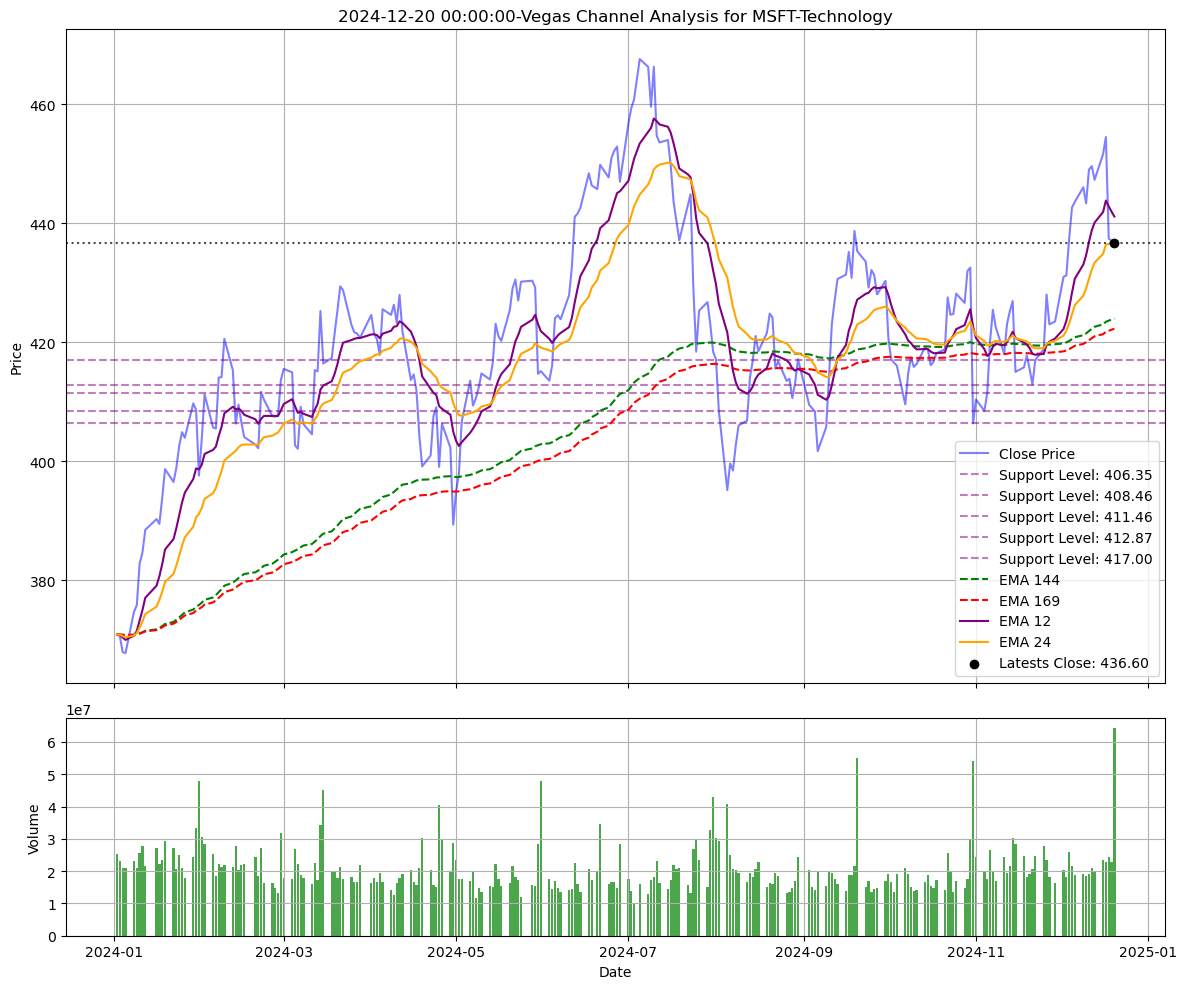

In [9]:
# Stock symbol and date range
symbol = 'MSFT'  # Microsoft
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol)
plt.close()

[*********************100%%**********************]  1 of 1 completed


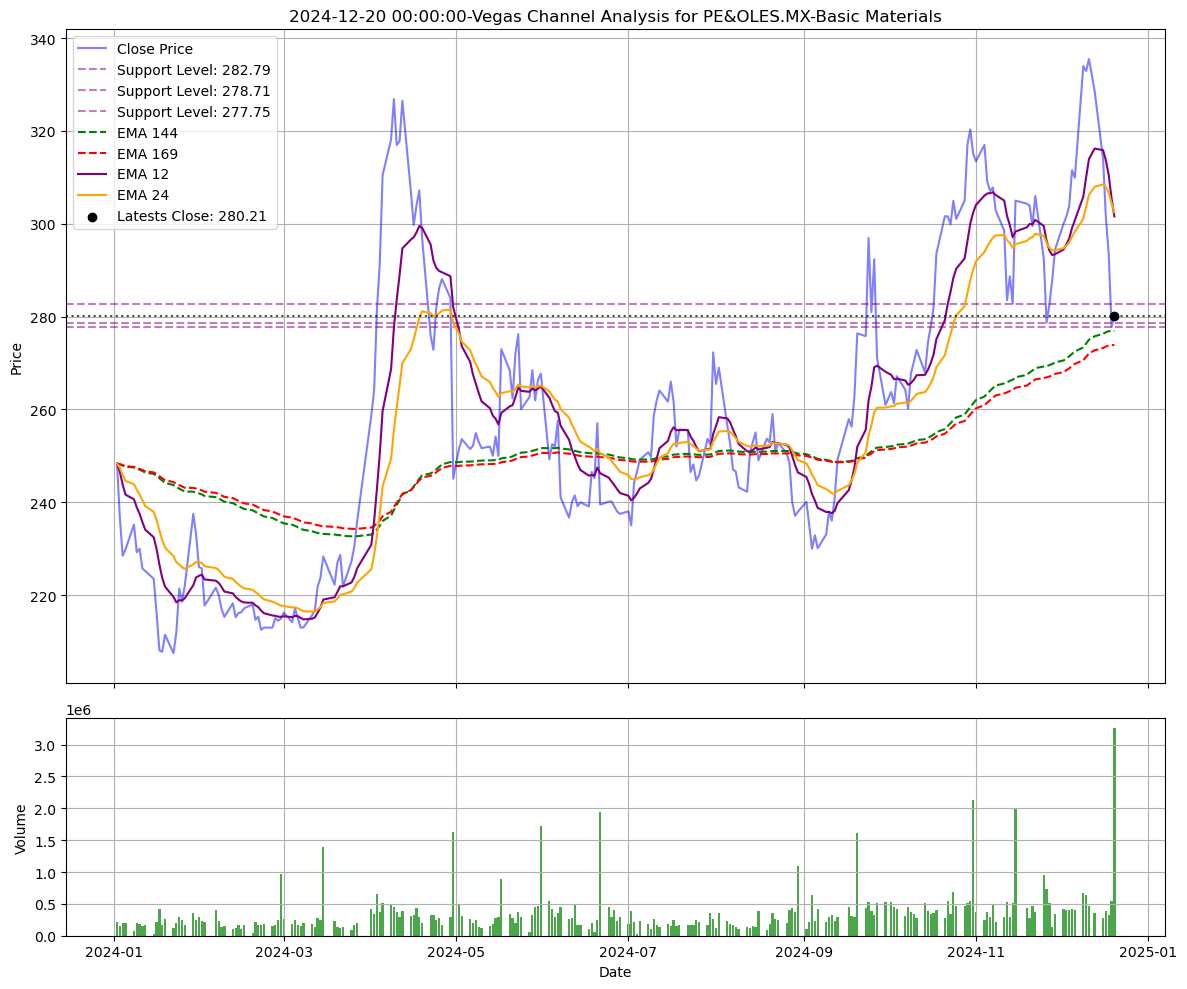

In [10]:
# Stock symbol and date range
symbol = 'PE&OLES.MX'  # Peñoles
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol)
plt.close()

[*********************100%%**********************]  1 of 1 completed


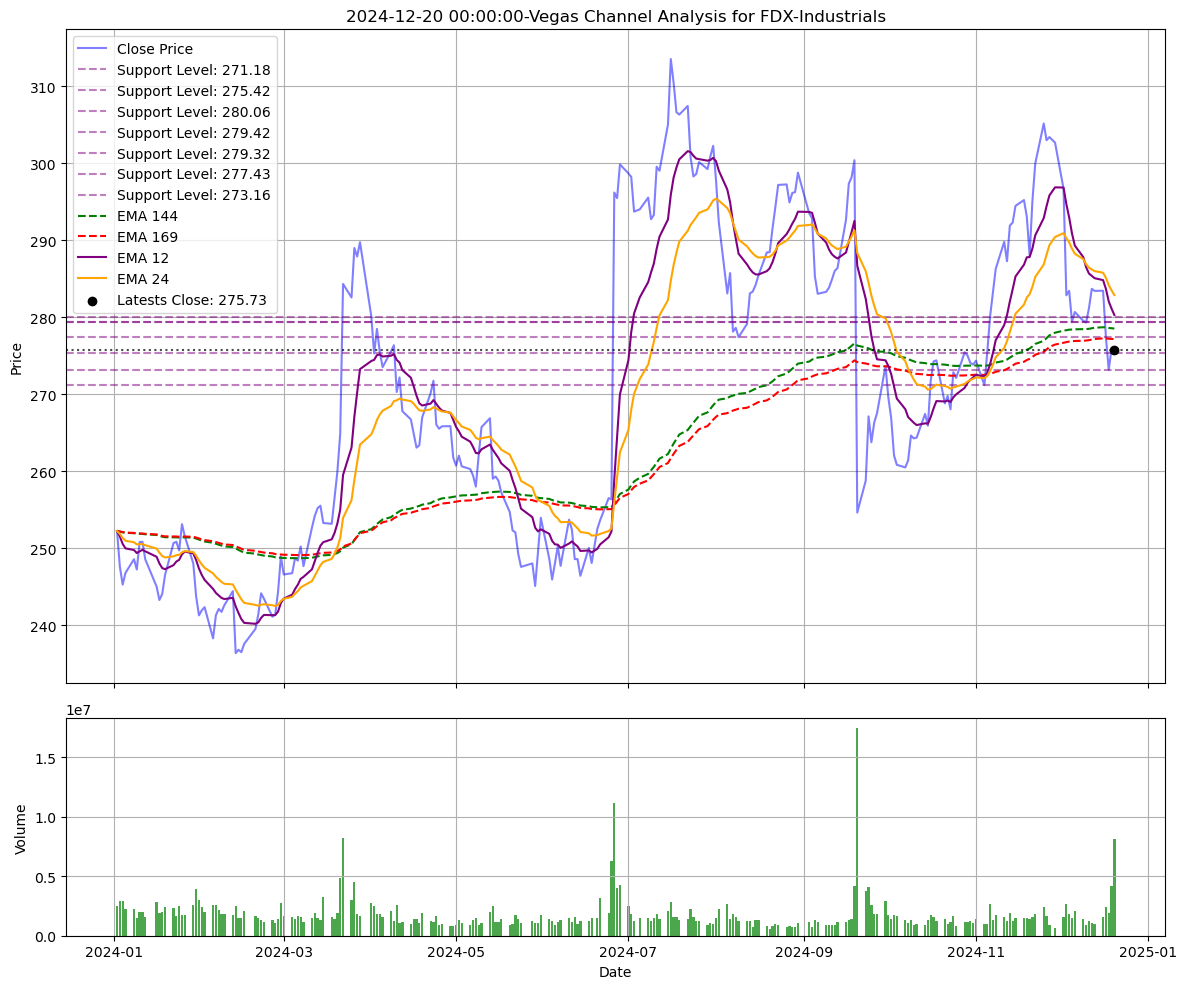

In [11]:
# Stock symbol and date range
symbol = 'FDX'  # FEDEX
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol)
plt.close()

[*********************100%%**********************]  1 of 1 completed


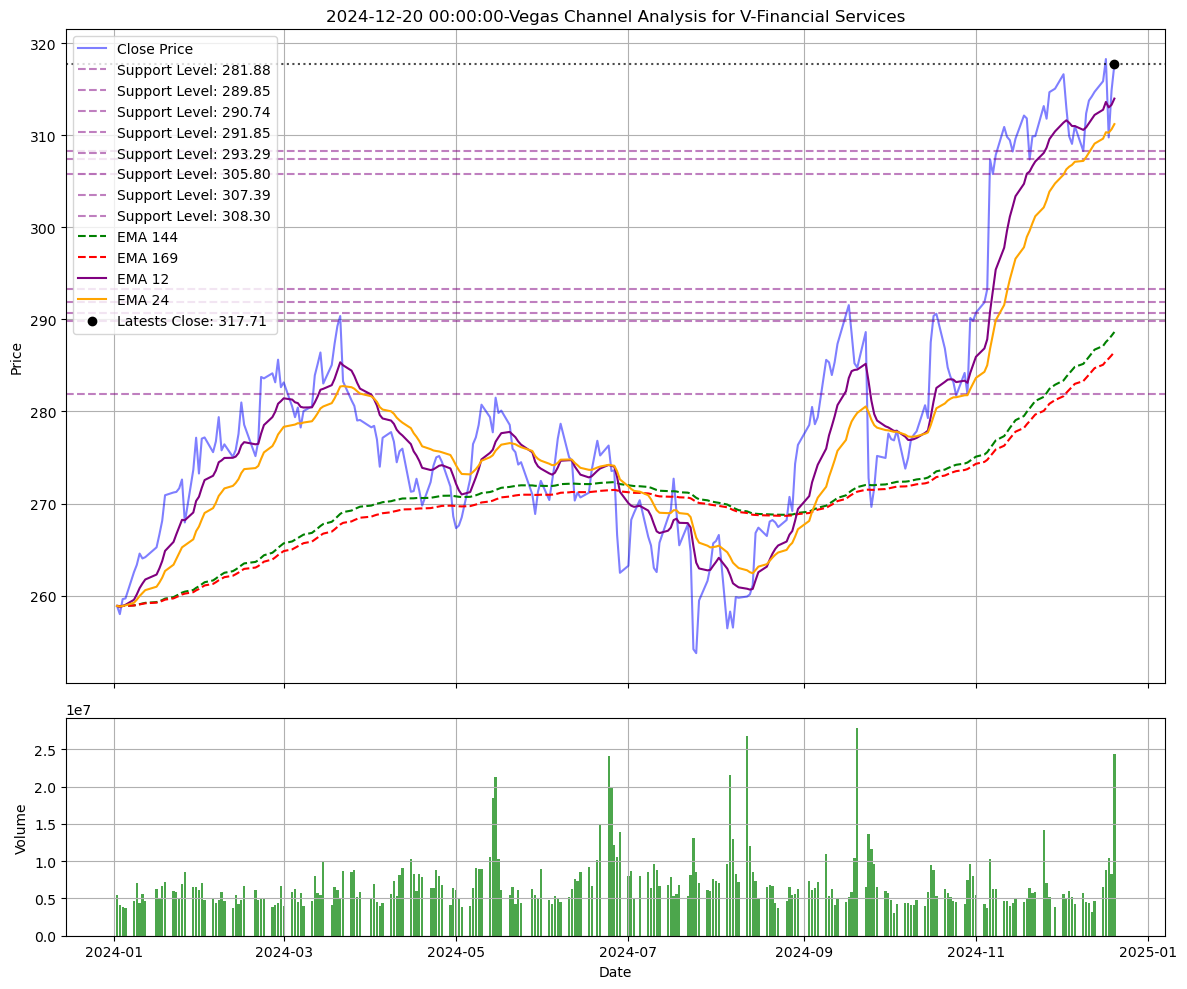

In [13]:
# Stock symbol and date range
symbol = 'V'  # Example: Apple stock
today = datetime.date.today()
# choose days = week_days * number_weeks ago
w_days = 7
n_weeks = 51
# some weeks from now
ago_weeks = datetime.timedelta(days=w_days * n_weeks)
last_weeks = today - ago_weeks
#start_date = '2023-01-01'
start_date = last_weeks
#end_date = '2023-10-10'
end_date = today

# Download stock data
stock_data = download_stock_data(symbol, start=start_date, end=end_date)

# Perform Vegas Channel Analysis (calculate EMAs)
stock_data = vegas_channel_analysis(stock_data)

# Plot the result
plot_vegas_channel(stock_data, symbol)
plt.close()